In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import re

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Style Settings ---
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")
sns.set_context("talk")

# --- Optional display tweaks for Jupyter ---
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)


In [ ]:
# Load
df = pd.read_excel("data/raw/CM Data Collection - Leo Cup (Responses).xlsx")

In [ ]:
# Columns we care about
keep_cols = [
    "Player IGN",
    "CM Group",
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)"
]

# Add all round columns automatically
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]
for prefix in round_prefixes:
    keep_cols += [c for c in df.columns if c.startswith(prefix)]

# Subset to relevant data only
df = df[keep_cols].copy()

In [ ]:
def normalize_role(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if "debuffer" in s or "hybrid" in s:
        return "Debuffer"
    if "aoharu made ace" in s or "ace" in s:
        return "Ace"
    return "Other"

def normalize_style(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if "front" in s: return "Front Runner"
    if "pace"  in s: return "Pace Chaser"
    if "late"  in s: return "Late Surger"
    if "end"   in s: return "End Closer"
    return "Unknown Style"

In [ ]:
# --------------------
# Columns of interest
# --------------------
prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

# Keep CM Group + LB columns as-is; convert LBs with map (avoids FutureWarning)
lb_map = {"0LB": 0, "1LB": 1, "2LB": 2, "3LB": 3, "MLB": 4}
for col in [
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)",
]:
    if col in df.columns:
        df[col] = df[col].map(lb_map).astype("Int64")  # nullable int, no downcast warning


In [ ]:
# --------------------
# Wins / Races per round: numeric (nullable) + Win Rate (%)
# Handle skipped players cleanly.
# --------------------
for p in prefixes:
    win_col  = f"{p} - No. of wins"
    race_col = f"{p} - No. of races played"

    # Create a "Played?" flag from Uma columns
    uma_cols = [f"{p} - Uma {i}" for i in (1, 2, 3) if f"{p} - Uma {i}" in df.columns]
    played_col = f"{p} - Played?"
    if uma_cols:
        df[played_col] = ~df[uma_cols].isna().all(axis=1)
    else:
        df[played_col] = False  # if no uma columns present, assume not played

    # Coerce wins/races to nullable ints, but don't invent zeros
    if win_col in df:
        df[win_col] = pd.to_numeric(df[win_col], errors="coerce").astype("Int64")
    if race_col in df:
        df[race_col] = pd.to_numeric(df[race_col], errors="coerce").astype("Int64")

    # If the player clearly did NOT play this round (no Umas), mark both as NA
    if win_col in df and race_col in df:
        skipped_mask = ~df[played_col]
        df.loc[skipped_mask, [win_col, race_col]] = pd.NA

        # Compute Win Rate only when races > 0
        wr_col = f"{p} - Win Rate (%)"
        df[wr_col] = ((df[win_col] / df[race_col]) * 100).where(df[race_col].gt(0))
        df[wr_col] = df[wr_col].round(2).astype("Float64")

In [ ]:
# Confirm LB dtypes are clean, nullable ints
print(df[["Kitasan Black LB in Account (Non-borrow)",
          "Super Creek LB in Account (Non-borrow)"]].dtypes)

# Check a sample of the round metrics + Played?
cols_show = []
for p in prefixes:
    for suffix in ["No. of wins", "No. of races played", "Win Rate (%)", "Played?"]:
        c = f"{p} - {suffix}"
        if c in df.columns:
            cols_show.append(c)

print(df[["CM Group"] + cols_show].head(10))


Kitasan Black LB in Account (Non-borrow)    Int64
Super Creek LB in Account (Non-borrow)      Int64
dtype: object
            CM Group  R1D1 - No. of wins  R1D1 - No. of races played  R1D1 - Win Rate (%)  R1D1 - Played?  R1D2 - No. of wins  R1D2 - No. of races played  R1D2 - Win Rate (%)  \
0  Graded (No Limit)                <NA>                        <NA>                 <NA>           False                <NA>                        <NA>                 <NA>   
1  Graded (No Limit)                  16                          20                 80.0            True                  15                          20                 75.0   
2  Graded (No Limit)                  18                          20                 90.0            True                  16                          20                 80.0   
3  Graded (No Limit)                  11                          20                 55.0            True                  16                          20                 80.0

In [ ]:
#  EDIT ME: Uma → Debuffer Type
DEBUFF_TYPE = {
    # Speed debuffers
    "Grass Wonder": "Speed",
    "Symboli Rudolf": "Speed",
    "Agnes Tachyon": "Speed",

    # Stamina debuffers
    "Nice Nature": "Stamina",
    "Mayano Top Gun (Wedding)": "Stamina",

    # Other debuffers
    "Air Groove": "Other",
    # Add more as needed...
}


In [ ]:
# --- Gather all Uma + Role pairs from R1D1, R1D2, R2D1, R2D2 ---
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]
role_cols = [f"{p} - Uma {i}" for p in round_prefixes for i in (1,2,3)]
role_cols += [f"{p} - Uma {i} Role" for p in round_prefixes for i in (1,2,3)]

# Get only valid columns
role_cols = [c for c in role_cols if c in df.columns]

# Melt Uma and Role pairs
uma_roles = []
for p in round_prefixes:
    for i in (1, 2, 3):
        uma_col = f"{p} - Uma {i}"
        role_col = f"{p} - Uma {i} Role"
        if uma_col in df.columns and role_col in df.columns:
            temp = df[[uma_col, role_col]].dropna()
            temp.columns = ["Uma", "Role"]
            temp["Uma"] = temp["Uma"].astype(str).str.strip().str.title()
            temp["Role"] = temp["Role"].astype(str).str.strip().str.title()
            uma_roles.append(temp)

uma_roles = pd.concat(uma_roles, ignore_index=True)

# --- Find Umas marked as Debuffers but not in DEBUFF_TYPE ---
mask_debuffer_role = uma_roles["Role"].str.contains("Debuffer", case=False, na=False)
debuffer_umas = uma_roles[mask_debuffer_role]["Uma"].value_counts().rename_axis("Uma").reset_index(name="Count")

# Filter: Debuffers in data but missing in DEBUFF_TYPE mapping
unmapped_debuffers = debuffer_umas[~debuffer_umas["Uma"].isin(DEBUFF_TYPE.keys())]

print("=== Umas marked as Debuffers (Role) but NOT in DEBUFF_TYPE mapping ===")
print(unmapped_debuffers)


=== Umas marked as Debuffers (Role) but NOT in DEBUFF_TYPE mapping ===
                    Uma  Count
6        Narita Taishin      5
7          Special Week      1
8           Rice Shower      1
9             Seiun Sky      1
10  Maruzensky (Summer)      1
11            Oguri Cap      1


In [ ]:
def has_debuffer(row, prefix):
    """Return True if team has ≥1 known debuffer Uma."""
    for i in (1, 2, 3):
        col = f"{prefix} - Uma {i}"
        if col in row and pd.notna(row[col]):
            uma = str(row[col]).strip().title()
            if uma in DEBUFF_TYPE:  # known debuffer (speed or stamina)
                return True
    return False

def build_round_team_wr_debuffer(df, prefix):
    """Compute WR for teams WITH vs WITHOUT debuffers for one round."""
    win_col  = f"{prefix} - No. of wins"
    race_col = f"{prefix} - No. of races played"
    uma_cols = [f"{prefix} - Uma {i}" for i in (1,2,3)]
    use_cols = [c for c in [win_col, race_col] + uma_cols if c in df.columns]

    if win_col not in df.columns or race_col not in df.columns:
        return pd.DataFrame(columns=["Round","HasDebuffer","Teams","Wins","Races","WinRate"])

    tmp = df[use_cols].copy()
    tmp[win_col]  = pd.to_numeric(tmp[win_col],  errors="coerce")
    tmp[race_col] = pd.to_numeric(tmp[race_col], errors="coerce")

    tmp["HasDebuffer"] = tmp.apply(lambda r: has_debuffer(r, prefix), axis=1)

    out = (tmp.groupby("HasDebuffer")
               .agg(Teams=(race_col, "count"),
                    Wins=(win_col, "sum"),
                    Races=(race_col, "sum"))
               .reset_index())
    out["Round"] = prefix
    out["WinRate"] = np.where(out["Races"] > 0, (out["Wins"]/out["Races"])*100, np.nan).round(2)
    return out[["Round","HasDebuffer","Teams","Wins","Races","WinRate"]]


In [ ]:
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

wr_debuffer_summary = pd.concat(
    [build_round_team_wr_debuffer(df, p) for p in round_prefixes],
    ignore_index=True
)

# Make labels cleaner
wr_debuffer_summary["HasDebuffer"] = wr_debuffer_summary["HasDebuffer"].map(
    {True: "With Debuffer", False: "No Debuffer"}
)

# Sort for nicer display
wr_debuffer_summary = wr_debuffer_summary.sort_values(["Round", "HasDebuffer"])
print(wr_debuffer_summary)


  Round    HasDebuffer  Teams  Wins  Races  WinRate
0  R1D1    No Debuffer    115  1584   2205    71.84
1  R1D1  With Debuffer    781  9957  14855    67.03
2  R1D2    No Debuffer    109  1496   2085    71.75
3  R1D2  With Debuffer    721  8999  13705    65.66
4  R2D1    No Debuffer    103  1156   1950    59.28
5  R2D1  With Debuffer    673  6870  13030    52.72
6  R2D2    No Debuffer    100  1191   1940    61.39
7  R2D2  With Debuffer    666  7173  12860    55.78


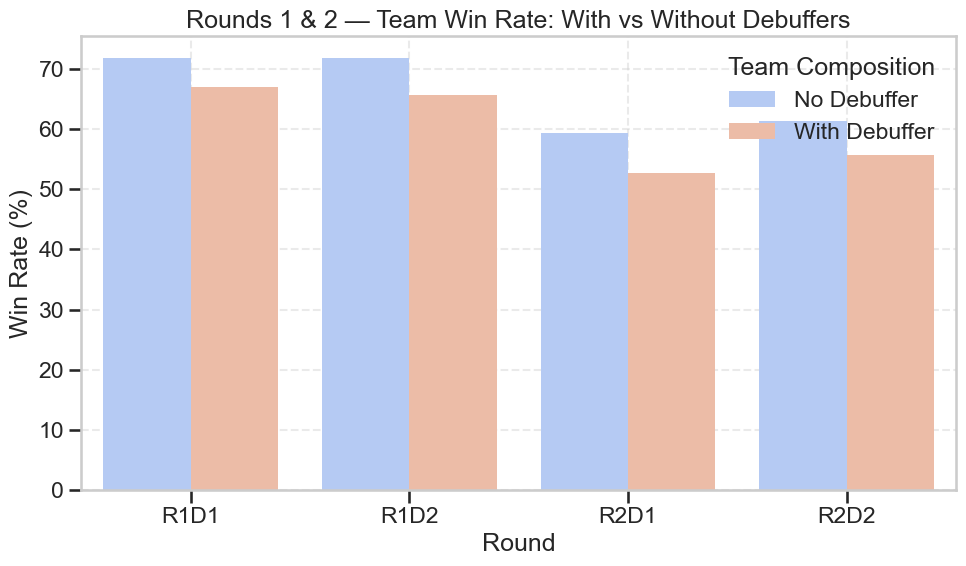

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=wr_debuffer_summary, x="Round", y="WinRate", hue="HasDebuffer", palette="coolwarm")
plt.title("Rounds 1 & 2 — Team Win Rate: With vs Without Debuffers")
plt.ylabel("Win Rate (%)")
plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Team Composition")
plt.tight_layout()
plt.show()


In [ ]:
def team_debuffer_type(row, prefix):
    """
    Returns one of:
    No Debuffer, Speed, Stamina, Other, or Mixed
    """
    umas = []
    for i in (1, 2, 3):
        col = f"{prefix} - Uma {i}"
        if col in row and pd.notna(row[col]):
            umas.append(str(row[col]).strip().title())

    # Identify debuffer types on team
    types = {DEBUFF_TYPE.get(u) for u in umas if u in DEBUFF_TYPE}
    types.discard(None)

    if not types:
        return "No Debuffer"
    if len(types) == 1:
        return list(types)[0]  # "Speed", "Stamina", or "Other"
    return "Mixed"


In [ ]:
def build_round_team_wr_by_debuffer_type(df, prefix):
    win_col  = f"{prefix} - No. of wins"
    race_col = f"{prefix} - No. of races played"
    uma_cols = [f"{prefix} - Uma {i}" for i in (1,2,3)]
    use_cols = [c for c in [win_col, race_col] + uma_cols if c in df.columns]

    if win_col not in df.columns or race_col not in df.columns:
        return pd.DataFrame(columns=["Round","DebufferType","Teams","Wins","Races","WinRate"])

    tmp = df[use_cols].copy()
    tmp[win_col]  = pd.to_numeric(tmp[win_col],  errors="coerce")
    tmp[race_col] = pd.to_numeric(tmp[race_col], errors="coerce")

    tmp["DebufferType"] = tmp.apply(lambda r: team_debuffer_type(r, prefix), axis=1)

    out = (tmp.groupby("DebufferType")
               .agg(Teams=(race_col, "count"),
                    Wins=(win_col, "sum"),
                    Races=(race_col, "sum"))
               .reset_index())
    out["Round"] = prefix
    out["WinRate"] = np.where(out["Races"] > 0, (out["Wins"]/out["Races"])*100, np.nan).round(2)
    return out[["Round","DebufferType","Teams","Wins","Races","WinRate"]]


In [ ]:
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

wr_debuffer_type_summary = pd.concat(
    [build_round_team_wr_by_debuffer_type(df, p) for p in round_prefixes],
    ignore_index=True
)

# Clean up order for nice plotting
order = ["No Debuffer", "Speed", "Stamina", "Other", "Mixed"]
wr_debuffer_type_summary["DebufferType"] = pd.Categorical(
    wr_debuffer_type_summary["DebufferType"], categories=order, ordered=True
)

print(wr_debuffer_type_summary.sort_values(["Round","DebufferType"]))


   Round DebufferType  Teams  Wins  Races  WinRate
1   R1D1  No Debuffer    115  1584   2205    71.84
3   R1D1        Speed    263  3503   5060    69.23
4   R1D1      Stamina    351  4621   6660    69.38
2   R1D1        Other      4    53     75    70.67
0   R1D1        Mixed    163  1780   3060    58.17
6   R1D2  No Debuffer    109  1496   2085    71.75
8   R1D2        Speed    270  3477   5175    67.19
9   R1D2      Stamina    305  3941   5810    67.83
7   R1D2        Other      4    41     65    63.08
5   R1D2        Mixed    142  1540   2655    58.00
11  R2D1  No Debuffer    103  1156   1950    59.28
13  R2D1        Speed    276  2970   5375    55.26
14  R2D1      Stamina    261  2716   5035    53.94
12  R2D1        Other      3    41     60    68.33
10  R2D1        Mixed    133  1143   2560    44.65
16  R2D2  No Debuffer    100  1191   1940    61.39
18  R2D2        Speed    297  3377   5790    58.32
19  R2D2      Stamina    233  2504   4515    55.46
17  R2D2        Other      3   

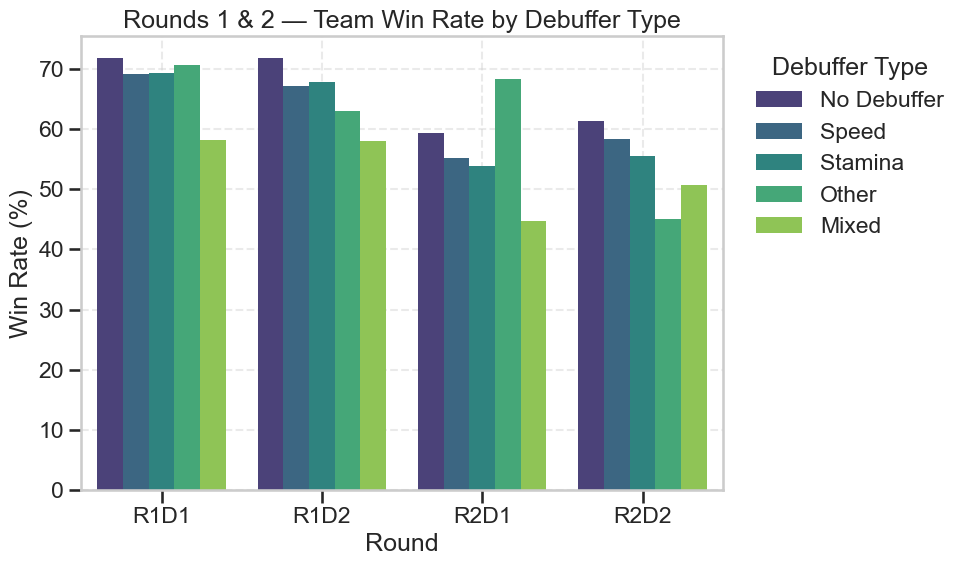

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=wr_debuffer_type_summary,
            x="Round", y="WinRate", hue="DebufferType", palette="viridis")
plt.title("Rounds 1 & 2 — Team Win Rate by Debuffer Type")
plt.ylabel("Win Rate (%)")
plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Debuffer Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# Collapse the previous per-round data into overall averages
wr_debuffer_trends = (
    wr_debuffer_type_summary
    .groupby(["Round", "DebufferType"], as_index=False)
    .agg(AvgWinRate=("WinRate", "mean"),
         TotalTeams=("Teams", "sum"))
)

# Sort rounds in logical order
round_order = ["R1D1", "R1D2", "R2D1", "R2D2"]
wr_debuffer_trends["Round"] = pd.Categorical(wr_debuffer_trends["Round"], categories=round_order, ordered=True)
wr_debuffer_trends = wr_debuffer_trends.sort_values(["DebufferType", "Round"])

wr_debuffer_trends.head()


C:\Users\white\AppData\Local\Temp\ipykernel_1604\3629225885.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Round", "DebufferType"], as_index=False)


,Round,DebufferType,AvgWinRate,TotalTeams
0,R1D1,No Debuffer,71.84,115
5,R1D2,No Debuffer,71.75,109
10,R2D1,No Debuffer,59.28,103
15,R2D2,No Debuffer,61.39,100
1,R1D1,Speed,69.23,263


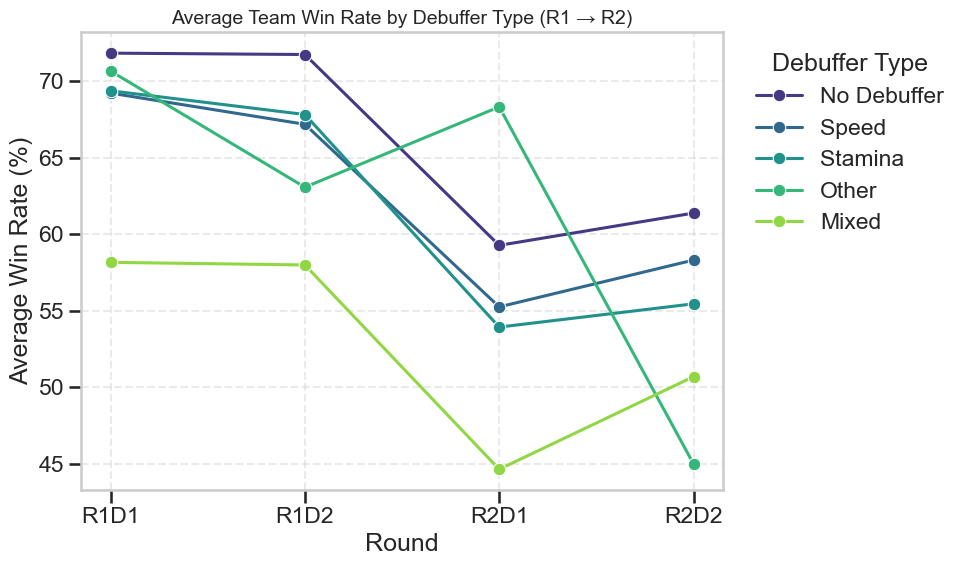

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=wr_debuffer_trends,
    x="Round", y="AvgWinRate", hue="DebufferType", 
    marker="o", linewidth=2.2, palette="viridis"
)
plt.title("Average Team Win Rate by Debuffer Type (R1 → R2)", fontsize=14)
plt.xlabel("Round")
plt.ylabel("Average Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Debuffer Type", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# Compute overall averages across all rounds
overall_avg_wr = (
    wr_debuffer_trends.groupby("DebufferType", as_index=False)
    .agg(
        OverallAvgWR=("AvgWinRate", "mean"),
        TotalTeams=("TotalTeams", "sum")
    )
    .sort_values("OverallAvgWR", ascending=False)
)

print(overall_avg_wr)


  DebufferType  OverallAvgWR  TotalTeams
0  No Debuffer       66.0650         427
1        Speed       62.5000        1106
3        Other       61.7700          14
2      Stamina       61.6525        1150
4        Mixed       52.8800         571


C:\Users\white\AppData\Local\Temp\ipykernel_1604\1845734649.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wr_debuffer_trends.groupby("DebufferType", as_index=False)


In [ ]:
# --- Ensure normalizer exists (Hybrid → Debuffer) ---
try:
    normalize_role
except NameError:
    def normalize_role(x):
        import pandas as pd, numpy as np
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if "debuffer" in s or "hybrid" in s or "domin" in s:  # dominator etc.
            return "Debuffer"
        if "ace" in s: return "Ace"
        return "Other"

# --- Build debuffer-only long table from R1/R2, using Role columns ---
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

rows = []
for p in round_prefixes:
    for i in (1, 2, 3):
        uma_col  = f"{p} - Uma {i}"
        role_col = f"{p} - Uma {i} Role"
        if uma_col in df.columns and role_col in df.columns:
            t = df[[uma_col, role_col]].dropna(subset=[role_col]).copy()
            t.columns = ["Uma", "Role"]
            # keep ONLY rows where that slot is actually marked as Debuffer (incl. Hybrid)
            t["RoleNorm"] = t["Role"].apply(normalize_role)
            t = t[t["RoleNorm"] == "Debuffer"].drop(columns=["RoleNorm"])
            if not t.empty:
                t["Uma"] = (t["Uma"].astype(str).str.strip()
                            .str.replace(r"\s+", " ", regex=True)
                            .str.title())
                t["Round"] = p
                t["Slot"]  = i
                rows.append(t)

debuffer_long = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["Uma","Role","Round","Slot"])

# --- Map to Speed / Stamina / Other via your DEBUFF_TYPE ---
# (DEBUFF_TYPE must contain only debuffer Umas with labels "Speed"/"Stamina"/"Other")
debuffer_long["Debuff Type"] = debuffer_long["Uma"].map(DEBUFF_TYPE)

# Split into mapped vs unmapped (still debuffers by Role, but not in your dictionary)
mapped_mask = debuffer_long["Debuff Type"].notna()
debuffer_long_mapped   = debuffer_long[mapped_mask].copy()
unmapped_debuffer_long = debuffer_long[~mapped_mask].copy()

# --- Counts: only debuffers (mapped) ---
debuffer_uma_counts = (
    debuffer_long_mapped
      .groupby(["Debuff Type","Uma"], as_index=False)
      .size()
      .rename(columns={"size":"Appearances"})
      .sort_values(["Debuff Type","Appearances","Uma"], ascending=[True, False, True])
)

# Totals per type (mapped only)
debuffer_type_totals = (
    debuffer_uma_counts.groupby("Debuff Type", as_index=False)["Appearances"].sum()
      .rename(columns={"Appearances":"Type Total"})
)

# Unmapped debuffer Umas (so you can update DEBUFF_TYPE)
unmapped_debuffer_counts = (
    unmapped_debuffer_long.groupby("Uma", as_index=False)
      .size().rename(columns={"size":"Appearances"})
      .sort_values(["Appearances","Uma"], ascending=[False, True])
)

# === Export (overwrite) Excel with the 4 sheets + unmapped block appended ===
out_xlsx = "data/processed/Debuffer_WR_Comparison_R1_R2.xlsx"

with pd.ExcelWriter(out_xlsx, engine="xlsxwriter", mode="w") as writer:
    # 1) Per-round WR by type
    wr_debuffer_type_summary.to_excel(writer, index=False, sheet_name="PerRound_WR_ByType")
    # 2) Trends
    wr_debuffer_trends.to_excel(writer, index=False, sheet_name="Trends")
    # 3) Overall
    overall_avg_wr.to_excel(writer, index=False, sheet_name="Overall")
    # 4) Debuffer_Umas (mapped only)
    debuffer_uma_counts.to_excel(writer, index=False, sheet_name="Debuffer_Umas")

    ws = writer.sheets["Debuffer_Umas"]
    # Append per-type totals a few rows below
    start_row = len(debuffer_uma_counts) + 3
    debuffer_type_totals.to_excel(writer, index=False, sheet_name="Debuffer_Umas", startrow=start_row)

    # If there are any unmapped debuffers, append them too
    if not unmapped_debuffer_counts.empty:
        start_row_unmapped = start_row + len(debuffer_type_totals) + 3
        ws.write_string(start_row_unmapped - 1, 0, "Unmapped Debuffer Umas (by Role, not in DEBUFF_TYPE):")
        unmapped_debuffer_counts.to_excel(writer, index=False, sheet_name="Debuffer_Umas", startrow=start_row_unmapped)

    # Autofit columns on all sheets
    for sheet_name, df_ in {
        "PerRound_WR_ByType": wr_debuffer_type_summary,
        "Trends": wr_debuffer_trends,
        "Overall": overall_avg_wr,
        "Debuffer_Umas": debuffer_uma_counts,
    }.items():
        ws2 = writer.sheets[sheet_name]
        for col_idx, col in enumerate(df_.columns):
            max_len = max(len(str(col)), *(len(str(v)) for v in df_[col].astype(str).values[:1000]))
            ws2.set_column(col_idx, col_idx, min(max_len + 2, 40))

print(f"✅ Debuffer-only counts exported to Debuffer_Umas (mapped), with totals; unmapped debuffers listed below if any → {out_xlsx}")


✅ Debuffer-only counts exported to Debuffer_Umas (mapped), with totals; unmapped debuffers listed below if any → data/processed/Debuffer_WR_Comparison_R1_R2.xlsx


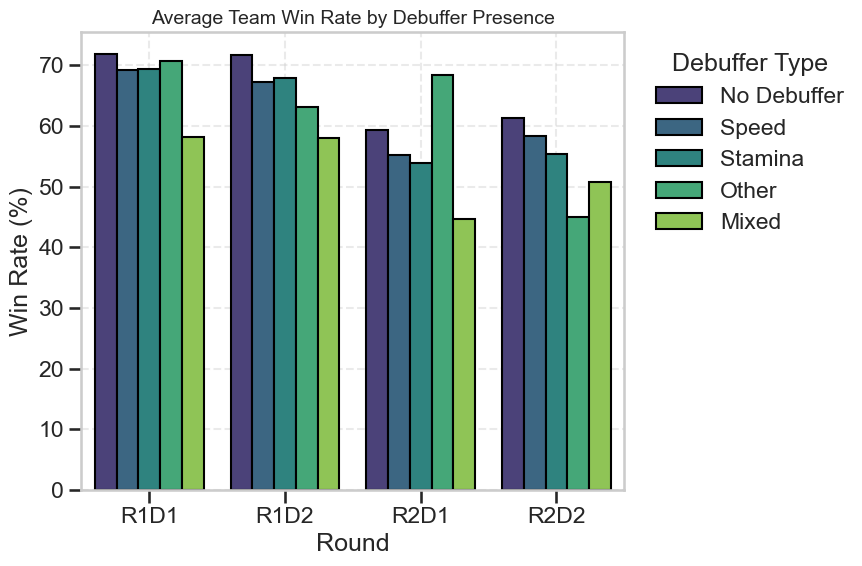

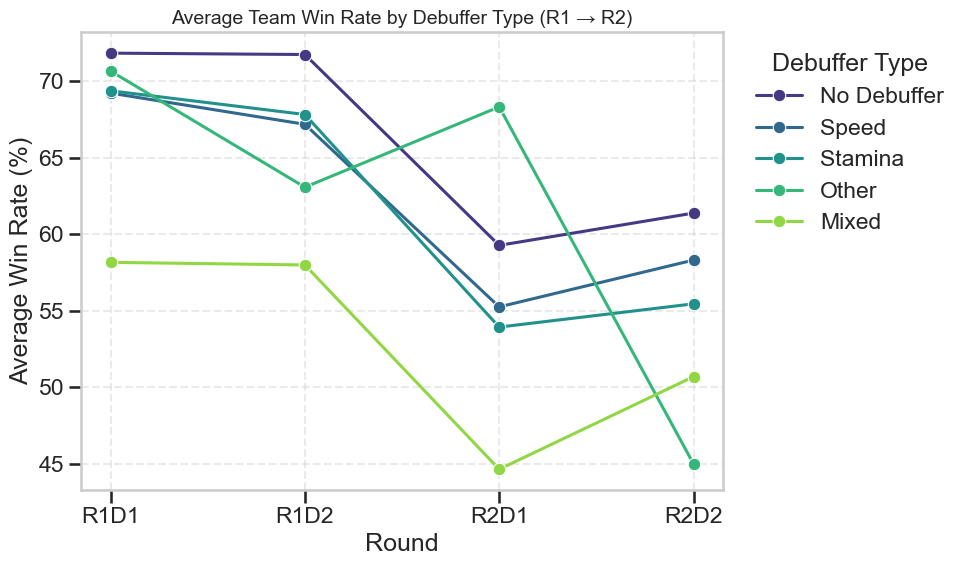

In [ ]:
# === 1 Win Rate Comparison: Debuffer vs Non-Debuffer Teams ===
plt.figure(figsize=(9, 6))
sns.barplot(
    data=wr_debuffer_type_summary,
    x="Round", y="WinRate", hue="DebufferType",
    palette="viridis", edgecolor="black"
)
plt.title("Average Team Win Rate by Debuffer Presence", fontsize=14)
plt.ylabel("Win Rate (%)")
plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Debuffer Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# === 2 Debuffer Type Trend Over Rounds (Speed/Stamina/Other/None) ===
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=wr_debuffer_trends,
    x="Round", y="AvgWinRate", hue="DebufferType",
    marker="o", linewidth=2.2, palette="viridis"
)
plt.title("Average Team Win Rate by Debuffer Type (R1 → R2)", fontsize=14)
plt.xlabel("Round")
plt.ylabel("Average Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Debuffer Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]
team_rows = []

for p in round_prefixes:
    if f"{p} - No. of wins" not in df.columns or f"{p} - No. of races played" not in df.columns:
        continue

    for idx, row in df.iterrows():
        wins = row.get(f"{p} - No. of wins", np.nan)
        total = row.get(f"{p} - No. of races played", np.nan)
        if pd.isna(total) or total == 0:
            continue
        
        debuff_count = 0
        debuff_types = set()
        
        for i in (1, 2, 3):
            role = row.get(f"{p} - Uma {i} Role", "")
            uma = row.get(f"{p} - Uma {i}", "")
            if isinstance(role, str) and ("debuffer" in role.lower() or "hybrid" in role.lower()):
                debuff_count += 1
                uma_norm = str(uma).strip().title()
                if uma_norm in DEBUFF_TYPE:
                    debuff_types.add(DEBUFF_TYPE[uma_norm])
                else:
                    debuff_types.add("Other")
        
        team_rows.append({
            "Round": p,
            "Wins": wins,
            "Total": total,
            "WinRate": (wins / total) * 100,
            "Debuffers": debuff_count,
            "Debuff_Types": ", ".join(sorted(debuff_types)) if debuff_types else "None"
        })

team_df = pd.DataFrame(team_rows)
team_df.head()

,Round,Wins,Total,WinRate,Debuffers,Debuff_Types
0,R1D1,16,20,80.000000,0,None
1,R1D1,18,20,90.000000,1,Speed
2,R1D1,11,20,55.000000,1,Speed
3,R1D1,17,20,85.000000,2,Speed
4,R1D1,10,15,66.666667,1,Stamina


In [ ]:
# Average WR by number of debuffers
wr_by_count = (
    team_df.groupby("Debuffers", as_index=False)
    .agg(AvgWR=("WinRate", "mean"), Teams=("WinRate", "count"))
)

# Average WR by type combination
wr_by_type = (
    team_df.groupby("Debuff_Types", as_index=False)
    .agg(AvgWR=("WinRate", "mean"), Teams=("WinRate", "count"))
    .sort_values("AvgWR", ascending=False)
)

print("Win Rate by Debuffer Count:\n", wr_by_count)
print("\nWin Rate by Debuffer Type Composition:\n", wr_by_type)


Win Rate by Debuffer Count:
    Debuffers      AvgWR  Teams
0          0  64.449458    554
1          1  61.646475   1981
2          2  57.742317    705
3          3  45.297619     28

Win Rate by Debuffer Type Composition:
      Debuff_Types      AvgWR  Teams
0            None  64.449458    554
2    Other, Speed  63.181818     11
4           Speed  62.391870   1025
6         Stamina  60.633232   1316
3  Other, Stamina  56.969697     22
5  Speed, Stamina  54.345992    316
1           Other  51.319444     24


C:\Users\white\AppData\Local\Temp\ipykernel_1604\1897707435.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wr_by_count, x="Debuffers", y="AvgWR", palette="viridis", edgecolor="black")


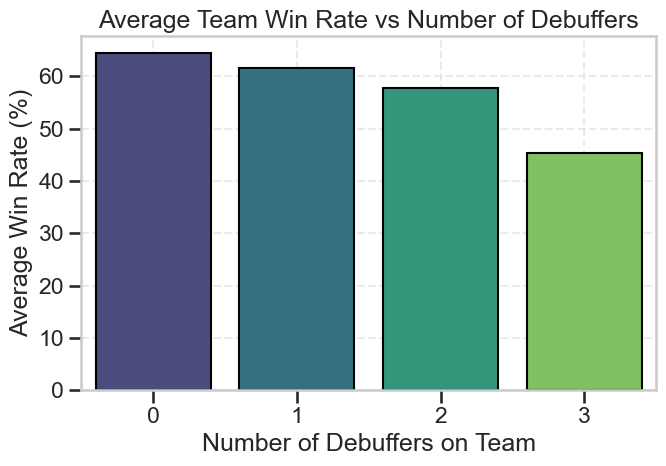

C:\Users\white\AppData\Local\Temp\ipykernel_1604\1897707435.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wr_by_type, x="Debuff_Types", y="AvgWR", palette="viridis", edgecolor="black")


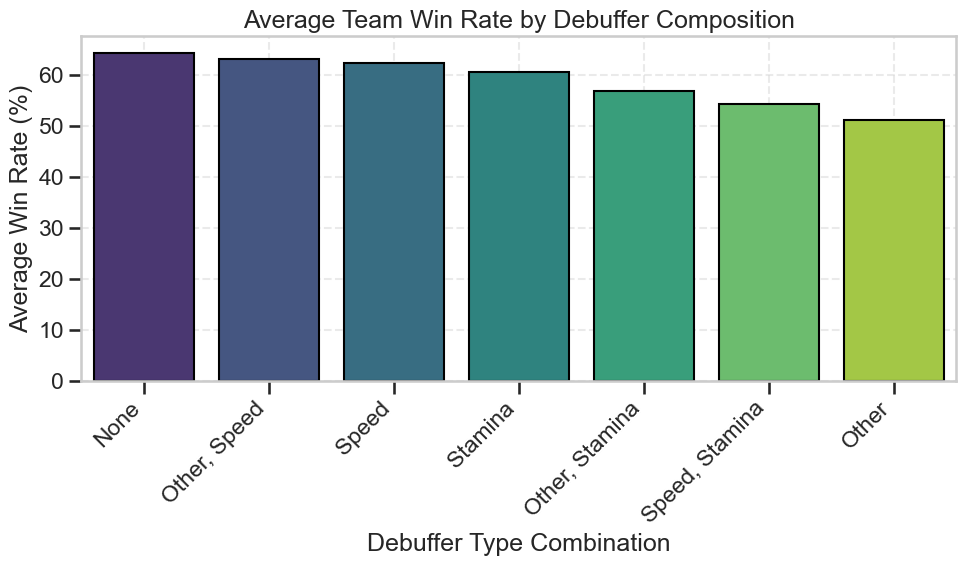

In [ ]:

# 1 Number of Debuffers vs Win Rate
plt.figure(figsize=(7,5))
sns.barplot(data=wr_by_count, x="Debuffers", y="AvgWR", palette="viridis", edgecolor="black")
plt.title("Average Team Win Rate vs Number of Debuffers")
plt.xlabel("Number of Debuffers on Team")
plt.ylabel("Average Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 2 Team Composition Type vs Win Rate
plt.figure(figsize=(10,6))
sns.barplot(data=wr_by_type, x="Debuff_Types", y="AvgWR", palette="viridis", edgecolor="black")
plt.title("Average Team Win Rate by Debuffer Composition")
plt.xlabel("Debuffer Type Combination")
plt.ylabel("Average Win Rate (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# --- Compute correlation-level summaries (as before) ---
wr_by_count = (
    team_df.groupby("Debuffers", as_index=False)
    .agg(AvgWR=("WinRate", "mean"), Teams=("WinRate", "count"))
)

wr_by_type = (
    team_df.groupby("Debuff_Types", as_index=False)
    .agg(AvgWR=("WinRate", "mean"), Teams=("WinRate", "count"))
    .sort_values("AvgWR", ascending=False)
)

# --- Overwrite the Excel file with ALL sheets ---
out_xlsx = "data/processed/Debuffer_WR_Comparison_R1_R2.xlsx"

with pd.ExcelWriter(out_xlsx, engine="xlsxwriter", mode="w") as writer:
    # 1 Per-round WR summaries
    wr_debuffer_type_summary.to_excel(writer, index=False, sheet_name="PerRound_WR_ByType")
    wr_debuffer_trends.to_excel(writer, index=False, sheet_name="Trends")
    overall_avg_wr.to_excel(writer, index=False, sheet_name="Overall")
    
    # 2 Debuffer-only Uma counts
    debuffer_uma_counts.to_excel(writer, index=False, sheet_name="Debuffer_Umas")
    ws = writer.sheets["Debuffer_Umas"]
    start_row = len(debuffer_uma_counts) + 3
    debuffer_type_totals.to_excel(writer, index=False, sheet_name="Debuffer_Umas", startrow=start_row)

    # Append unmapped debuffers if any
    if 'unmapped_debuffer_counts' in locals() and not unmapped_debuffer_counts.empty:
        start_row_unmapped = start_row + len(debuffer_type_totals) + 3
        ws.write_string(start_row_unmapped - 1, 0, "Unmapped Debuffer Umas (by Role, not in DEBUFF_TYPE):")
        unmapped_debuffer_counts.to_excel(writer, index=False, sheet_name="Debuffer_Umas", startrow=start_row_unmapped)

    # 3 Team-level correlation sheets
    wr_by_count.to_excel(writer, index=False, sheet_name="Team_WR_By_DebuffCount")
    wr_by_type.to_excel(writer, index=False, sheet_name="Team_WR_By_DebuffType")

    # 4 Auto-fit columns for all sheets
    for sheet_name, df_ in {
        "PerRound_WR_ByType": wr_debuffer_type_summary,
        "Trends": wr_debuffer_trends,
        "Overall": overall_avg_wr,
        "Debuffer_Umas": debuffer_uma_counts,
        "Team_WR_By_DebuffCount": wr_by_count,
        "Team_WR_By_DebuffType": wr_by_type,
    }.items():
        ws2 = writer.sheets[sheet_name]
        for col_idx, col in enumerate(df_.columns):
            max_len = max(len(str(col)), *(len(str(v)) for v in df_[col].astype(str).values[:1000]))
            ws2.set_column(col_idx, col_idx, min(max_len + 2, 40))

print(f" Excel overwritten → {out_xlsx}\nSheets included:\n- PerRound_WR_ByType\n- Trends\n- Overall\n- Debuffer_Umas\n- Team_WR_By_DebuffCount\n- Team_WR_By_DebuffType")


✅ Excel overwritten → data/processed/Debuffer_WR_Comparison_R1_R2.xlsx
Sheets included:
- PerRound_WR_ByType
- Trends
- Overall
- Debuffer_Umas
- Team_WR_By_DebuffCount
- Team_WR_By_DebuffType


In [ ]:
# --- Minimal role normalizer (Hybrid/Dominator -> Debuffer) if not defined ---
try:
    normalize_role
except NameError:
    def normalize_role(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if ("debuffer" in s) or ("hybrid" in s) or ("domin" in s):
            return "Debuffer"
        if "ace" in s:
            return "Ace"
        return "Other"

# --- Config: rounds we care about ---
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

# --- Helper: count per-type debuffers on a single row for a given round prefix ---
def count_debuffers_round_row(row, prefix, debuff_map):
    speed = stamina = other = 0
    for i in (1, 2, 3):
        role = row.get(f"{prefix} - Uma {i} Role", "")
        uma  = row.get(f"{prefix} - Uma {i}", "")
        if isinstance(role, str) and (("debuffer" in role.lower()) or ("hybrid" in role.lower()) or ("domin" in role.lower())):
            uma_norm = str(uma).strip().title()
            t = debuff_map.get(uma_norm)
            if t == "Speed":
                speed += 1
            elif t == "Stamina":
                stamina += 1
            else:
                # Unknown debuffer names default to Other; change to "continue" if you want to exclude unknowns
                other += 1
    return speed, stamina, other

# --- Build team-level dataframe for R1/R2 with counts and WinRate ---
team_rows = []
for p in round_prefixes:
    wins_col  = f"{p} - No. of wins"
    races_col = f"{p} - No. of races played"
    if wins_col not in df.columns or races_col not in df.columns:
        continue
    for _, row in df.iterrows():
        wins  = row.get(wins_col, np.nan)
        races = row.get(races_col, np.nan)
        # keep only teams that actually reported races
        if pd.isna(races) or float(races) <= 0:
            continue
        spd, sta, oth = count_debuffers_round_row(row, p, DEBUFF_TYPE)
        total = spd + sta + oth
        # team-level win rate for that entry (wins/races * 100)
        try:
            wr = (float(wins) / float(races)) * 100.0
        except Exception:
            wr = np.nan
        team_rows.append({
            "Round": p,
            "Wins": wins,
            "Races": races,
            "WinRate": wr,
            "Speed_Count": spd,
            "Stamina_Count": sta,
            "Other_Count": oth,
            "Total_Debuffers": total,
            "Type_Pattern": f"S={spd},T={sta},O={oth}",
        })

r12_team_df = pd.DataFrame(team_rows)

# --- Summaries ---

# 1) WR vs Total_Debuffers (per round)
wr_by_total_per_round = (
    r12_team_df.groupby(["Round", "Total_Debuffers"], as_index=False)
    .agg(AvgWR=("WinRate", "mean"),
         Teams=("WinRate", "count"),
         TotalWins=("Wins", "sum"),
         TotalRaces=("Races", "sum"))
    .sort_values(["Round", "Total_Debuffers"])
)
wr_by_total_per_round["PooledWR(%)"] = np.where(
    wr_by_total_per_round["TotalRaces"] > 0,
    wr_by_total_per_round["TotalWins"] / wr_by_total_per_round["TotalRaces"] * 100.0,
    np.nan
).round(2)

# 1b) WR vs Total_Debuffers (overall across rounds)
wr_by_total_overall = (
    r12_team_df.groupby("Total_Debuffers", as_index=False)
    .agg(AvgWR=("WinRate", "mean"),
         Teams=("WinRate", "count"),
         TotalWins=("Wins", "sum"),
         TotalRaces=("Races", "sum"))
    .sort_values("Total_Debuffers")
)
wr_by_total_overall["PooledWR(%)"] = np.where(
    wr_by_total_overall["TotalRaces"] > 0,
    wr_by_total_overall["TotalWins"] / wr_by_total_overall["TotalRaces"] * 100.0,
    np.nan
).round(2)

# 2) WR vs (Speed_Count, Stamina_Count, Other_Count) pattern (per round)
wr_by_pattern_per_round = (
    r12_team_df.groupby(["Round","Speed_Count","Stamina_Count","Other_Count","Type_Pattern"], as_index=False)
    .agg(AvgWR=("WinRate", "mean"),
         Teams=("WinRate", "count"),
         TotalWins=("Wins", "sum"),
         TotalRaces=("Races", "sum"))
    .sort_values(["Round","AvgWR","Teams"], ascending=[True, False, False])
)
wr_by_pattern_per_round["PooledWR(%)"] = np.where(
    wr_by_pattern_per_round["TotalRaces"] > 0,
    wr_by_pattern_per_round["TotalWins"] / wr_by_pattern_per_round["TotalRaces"] * 100.0,
    np.nan
).round(2)

# 2b) WR vs pattern (overall)
wr_by_pattern_overall = (
    r12_team_df.groupby(["Speed_Count","Stamina_Count","Other_Count","Type_Pattern"], as_index=False)
    .agg(AvgWR=("WinRate", "mean"),
         Teams=("WinRate", "count"),
         TotalWins=("Wins", "sum"),
         TotalRaces=("Races", "sum"))
    .sort_values(["AvgWR","Teams"], ascending=[False, False])
)
wr_by_pattern_overall["PooledWR(%)"] = np.where(
    wr_by_pattern_overall["TotalRaces"] > 0,
    wr_by_pattern_overall["TotalWins"] / wr_by_pattern_overall["TotalRaces"] * 100.0,
    np.nan
).round(2)

# 3) WR vs per-type count (per round) — long format
def _per_type_long(df, type_col, label):
    out = (df.groupby(["Round", type_col], as_index=False)
             .agg(AvgWR=("WinRate","mean"),
                  Teams=("WinRate","count"),
                  TotalWins=("Wins","sum"),
                  TotalRaces=("Races","sum")))
    out.insert(1, "Type", label)
    out.rename(columns={type_col: "Count"}, inplace=True)
    out["PooledWR(%)"] = np.where(out["TotalRaces"] > 0, out["TotalWins"] / out["TotalRaces"] * 100.0, np.nan).round(2)
    return out

wr_speed_counts_r = _per_type_long(r12_team_df, "Speed_Count",   "Speed")
wr_stam_counts_r  = _per_type_long(r12_team_df, "Stamina_Count", "Stamina")
wr_other_counts_r = _per_type_long(r12_team_df, "Other_Count",   "Other")
wr_per_type_count_per_round = pd.concat([wr_speed_counts_r, wr_stam_counts_r, wr_other_counts_r], ignore_index=True)

# 3b) WR vs per-type count (overall across rounds)
def _per_type_overall(df, type_col, label):
    out = (df.groupby(type_col, as_index=False)
             .agg(AvgWR=("WinRate","mean"),
                  Teams=("WinRate","count"),
                  TotalWins=("Wins","sum"),
                  TotalRaces=("Races","sum")))
    out.insert(0, "Type", label)
    out.rename(columns={type_col: "Count"}, inplace=True)
    out["PooledWR(%)"] = np.where(out["TotalRaces"] > 0, out["TotalWins"] / out["TotalRaces"] * 100.0, np.nan).round(2)
    return out

wr_speed_counts_o = _per_type_overall(r12_team_df, "Speed_Count",   "Speed")
wr_stam_counts_o  = _per_type_overall(r12_team_df, "Stamina_Count", "Stamina")
wr_other_counts_o = _per_type_overall(r12_team_df, "Other_Count",   "Other")
wr_per_type_count_overall = pd.concat([wr_speed_counts_o, wr_stam_counts_o, wr_other_counts_o], ignore_index=True)

# --- (Optional) quick sanity prints ---
print("R1–R2 — WR vs Total Debuffers (per round)\n", wr_by_total_per_round.head())
print("\nR1–R2 — WR vs Total Debuffers (overall)\n", wr_by_total_overall)
print("\nR1–R2 — WR vs Pattern (per round)\n", wr_by_pattern_per_round.head())
print("\nR1–R2 — WR vs Pattern (overall)\n", wr_by_pattern_overall.head())
print("\nR1–R2 — WR vs Per-Type Count (per round)\n", wr_per_type_count_per_round.head())
print("\nR1–R2 — WR vs Per-Type Count (overall)\n", wr_per_type_count_overall)

# --- Excel export (OVERWRITE) ---
try:
    import xlsxwriter
    engine = "xlsxwriter"
except Exception:
    engine = "openpyxl"

out_xlsx = "data/processed/Rounds12_Debuffer_Analysis.xlsx"

with pd.ExcelWriter(out_xlsx, engine=engine, mode="w") as writer:
    # Full team-level detail (auditable)
    r12_team_df.to_excel(writer, index=False, sheet_name="Team_Detail")

    # Summaries
    wr_by_total_per_round.to_excel(writer, index=False, sheet_name="WR_By_TotalDebuffers_Round")
    wr_by_total_overall.to_excel(writer, index=False, sheet_name="WR_By_TotalDebuffers_All")

    wr_by_pattern_per_round.to_excel(writer, index=False, sheet_name="WR_By_Pattern_Round")
    wr_by_pattern_overall.to_excel(writer, index=False, sheet_name="WR_By_Pattern_All")

    wr_per_type_count_per_round.to_excel(writer, index=False, sheet_name="WR_PerTypeCount_Round")
    wr_per_type_count_overall.to_excel(writer, index=False, sheet_name="WR_PerTypeCount_All")

    # Autofit (xlsxwriter only)
    if engine == "xlsxwriter":
        for sheet_name, df_ in {
            "Team_Detail": r12_team_df,
            "WR_By_TotalDebuffers_Round": wr_by_total_per_round,
            "WR_By_TotalDebuffers_All": wr_by_total_overall,
            "WR_By_Pattern_Round": wr_by_pattern_per_round,
            "WR_By_Pattern_All": wr_by_pattern_overall,
            "WR_PerTypeCount_Round": wr_per_type_count_per_round,
            "WR_PerTypeCount_All": wr_per_type_count_overall,
        }.items():
            ws = writer.sheets[sheet_name]
            for col_idx, col in enumerate(df_.columns):
                max_len = max(len(str(col)), *(len(str(v)) for v in df_[col].astype(str).values[:1000]))
                ws.set_column(col_idx, col_idx, min(max_len + 2, 40))

print(f" Rounds 1–2 Excel written → {out_xlsx}")

R1–R2 — WR vs Total Debuffers (per round)
   Round  Total_Debuffers      AvgWR  Teams  TotalWins  TotalRaces  PooledWR(%)
0  R1D1                0  71.038813    146       1997        2775        71.96
1  R1D1                1  68.461538    546       7167       10440        68.65
2  R1D1                2  62.253401    196       2301        3690        62.36
3  R1D1                3  49.166667      8         76         155        49.03
4  R1D2                0  68.196347    146       1904        2760        68.99

R1–R2 — WR vs Total Debuffers (overall)
    Total_Debuffers      AvgWR  Teams  TotalWins  TotalRaces  PooledWR(%)
0                0  64.449458    554       6867       10545        65.12
1                1  61.646475   1981      23619       38230        61.78
2                2  57.742317    705       7691       13305        57.81
3                3  45.297619     28        249         550        45.27

R1–R2 — WR vs Pattern (per round)
    Round  Speed_Count  Stamina_Count  Ot

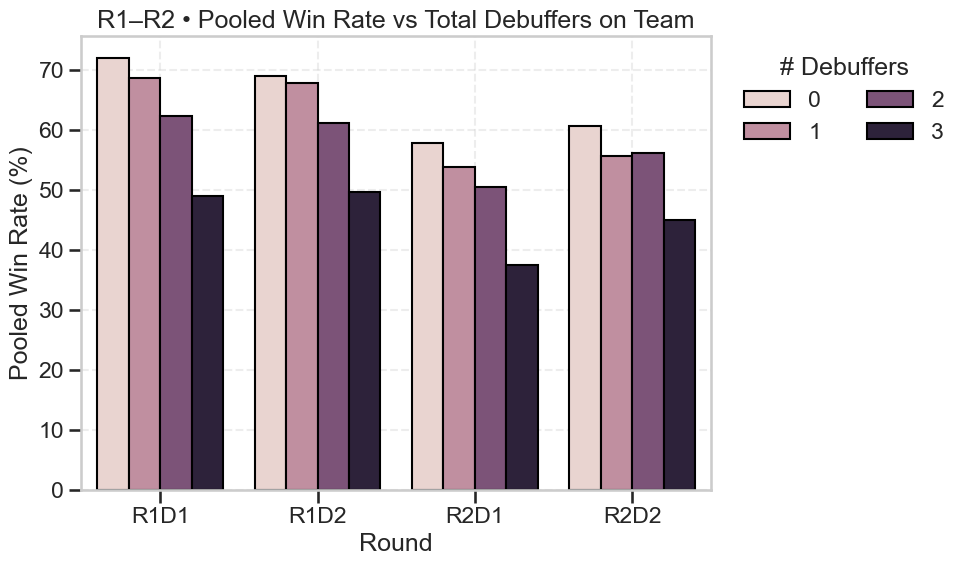

In [ ]:
r12_total_wr = wr_by_total_per_round.copy()
r12_total_wr["Round"] = pd.Categorical(r12_total_wr["Round"], categories=round_order, ordered=True)

plt.figure(figsize=(10,6))
sns.barplot(data=r12_total_wr, x="Round", y="PooledWR(%)", hue="Total_Debuffers", edgecolor="black")
plt.title("R1–R2 • Pooled Win Rate vs Total Debuffers on Team")
plt.ylabel("Pooled Win Rate (%)"); plt.xlabel("Round")
plt.legend(title="# Debuffers", ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


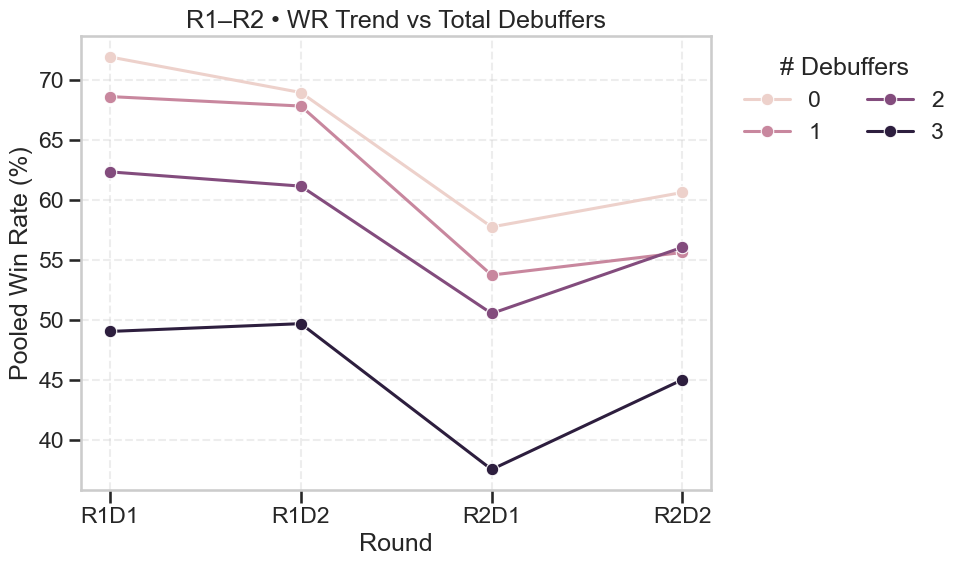

In [ ]:
r12_trend_wr = wr_by_total_per_round.copy()
r12_trend_wr["Round"] = pd.Categorical(r12_trend_wr["Round"], categories=round_order, ordered=True)

plt.figure(figsize=(10,6))
sns.lineplot(data=r12_trend_wr, x="Round", y="PooledWR(%)", hue="Total_Debuffers", marker="o", linewidth=2.2)
plt.title("R1–R2 • WR Trend vs Total Debuffers")
plt.ylabel("Pooled Win Rate (%)"); plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="# Debuffers", ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


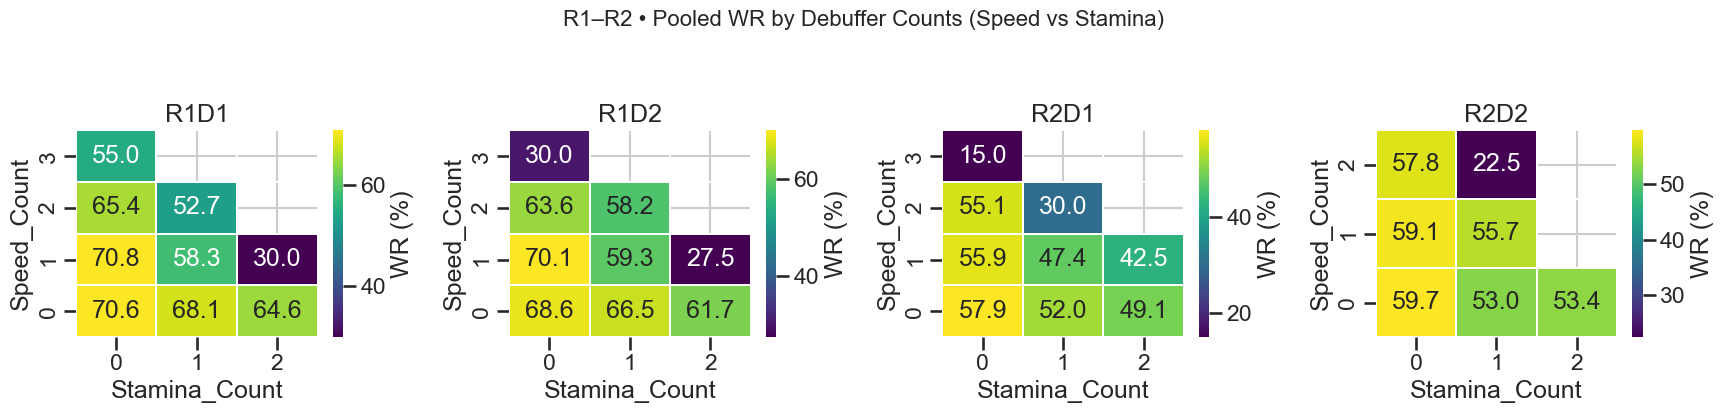

In [ ]:
r12_heat_df = (
    r12_team_df
    .groupby(["Round","Speed_Count","Stamina_Count"], as_index=False)
    .agg(TotalWins=("Wins","sum"), TotalRaces=("Races","sum"))
)
r12_heat_df["PooledWR(%)"] = np.where(r12_heat_df["TotalRaces"]>0,
                                      r12_heat_df["TotalWins"]/r12_heat_df["TotalRaces"]*100, np.nan)

g = sns.FacetGrid(r12_heat_df, col="Round", col_order=round_order, sharex=False, sharey=False, height=4, aspect=1.1)

def _draw_heat(data, **kws):
    pivot = (
    data.pivot(index="Speed_Count", columns="Stamina_Count", values="PooledWR(%)")
         .sort_index(ascending=False)           # sort Speed_Count (y-axis)
         .sort_index(axis=1, ascending=True)   # also sort Stamina_Count (x-axis)
)
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis", linewidths=0.3, cbar_kws={"label":"WR (%)"})
    plt.xlabel("Stamina_Count"); plt.ylabel("Speed_Count")

g.map_dataframe(_draw_heat)
g.set_titles(col_template="{col_name}")
plt.suptitle("R1–R2 • Pooled WR by Debuffer Counts (Speed vs Stamina)", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


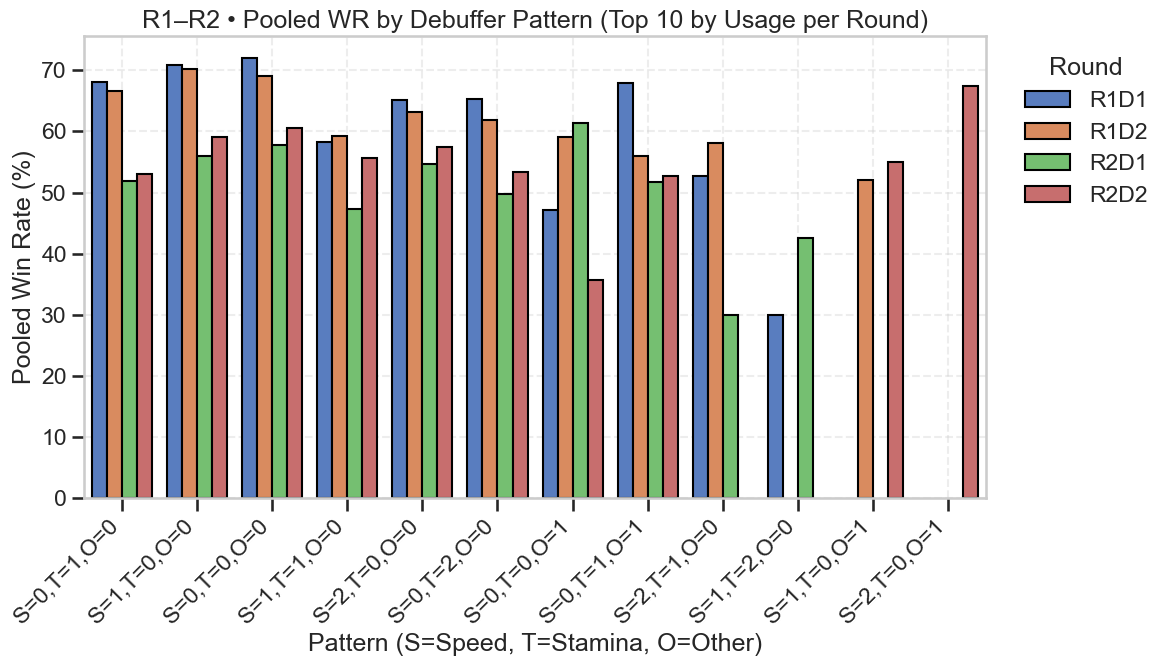

In [ ]:
r12_pattern_top = (
    wr_by_pattern_per_round
    .sort_values(["Round","Teams"], ascending=[True, False])
    .groupby("Round").head(10)
)
r12_pattern_top["Round"] = pd.Categorical(r12_pattern_top["Round"], categories=round_order, ordered=True)

plt.figure(figsize=(12,7))
sns.barplot(data=r12_pattern_top, x="Type_Pattern", y="PooledWR(%)", hue="Round", edgecolor="black")
plt.title("R1–R2 • Pooled WR by Debuffer Pattern (Top 10 by Usage per Round)")
plt.xlabel("Pattern (S=Speed, T=Stamina, O=Other)"); plt.ylabel("Pooled Win Rate (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="Round", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


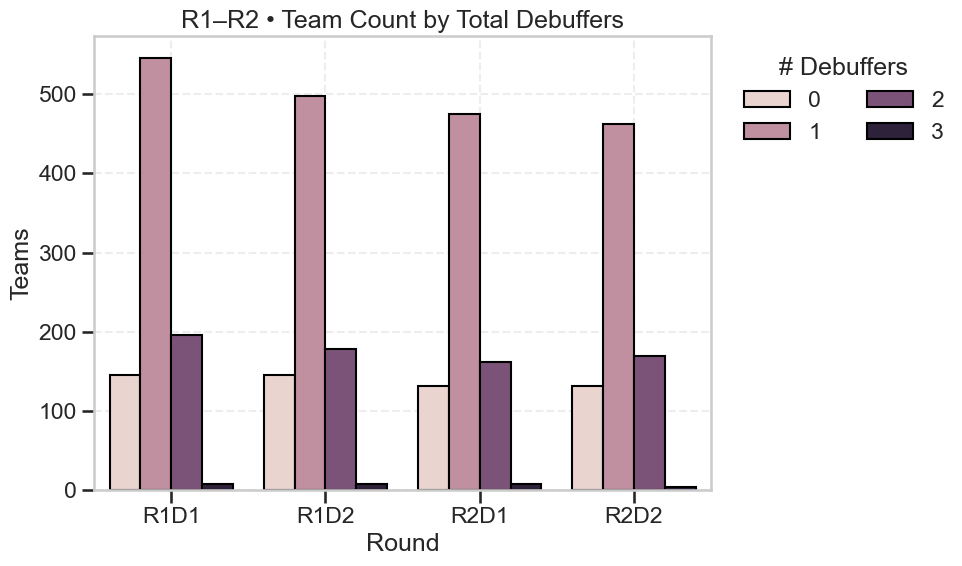

In [ ]:
r12_dist = (
    r12_team_df
    .groupby(["Round","Total_Debuffers"], as_index=False)
    .size().rename(columns={"size":"Teams"})
)
r12_dist["Round"] = pd.Categorical(r12_dist["Round"], categories=round_order, ordered=True)

plt.figure(figsize=(10,6))
sns.barplot(data=r12_dist, x="Round", y="Teams", hue="Total_Debuffers", edgecolor="black")
plt.title("R1–R2 • Team Count by Total Debuffers")
plt.ylabel("Teams"); plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="# Debuffers", ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()
